# How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our [data](../../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader.data as web

from pyfinance.ols import PandasRollingOLS
from talib import RSI, BBANDS, MACD, NATR, ATR

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load US equity OHLCV data

The `assets.h5` store can be generated using the the notebook [create_datasets](../../data/create_datasets.ipynb) in the [data](../../data) directory in the root directory of this repo for instruction to download the following dataset.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

In [4]:
DATA_STORE = './data/assets.h5'

In [5]:
YEAR = 12

In [6]:
START = 1995
END = 2017

In [7]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], :]
              .filter(like='adj_')
              .dropna()
              .swaplevel()
              .rename(columns=lambda x: x.replace('adj_', ''))
              .join(store['us_equities/stocks']
                    .loc[:, ['sector']])
              .dropna())

In [8]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10241831 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count     Dtype  
---  ------  --------------     -----  
 0   open    10241831 non-null  float64
 1   high    10241831 non-null  float64
 2   low     10241831 non-null  float64
 3   close   10241831 non-null  float64
 4   volume  10241831 non-null  float64
 5   sector  10241831 non-null  object 
dtypes: float64(5), object(1)
memory usage: 508.7+ MB


In [9]:
len(prices.index.unique('ticker'))

2369

## Remove stocks with less than ten years of data

In [10]:
min_obs = 10 * 252
nobs = prices.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
prices = prices.drop(to_drop, level='ticker')

In [11]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9532628 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    9532628 non-null  float64
 1   high    9532628 non-null  float64
 2   low     9532628 non-null  float64
 3   close   9532628 non-null  float64
 4   volume  9532628 non-null  float64
 5   sector  9532628 non-null  object 
dtypes: float64(5), object(1)
memory usage: 473.5+ MB


In [12]:
len(prices.index.unique('ticker'))

1883

## Add some Basic Factors

### Compute the Relative Strength Index

In [13]:
prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI)

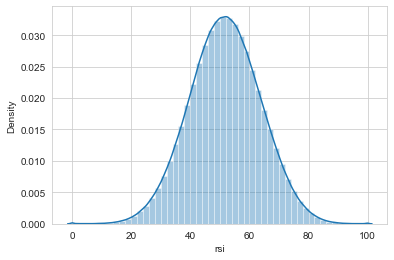

In [14]:
sns.distplot(prices.rsi);

### Compute Bollinger Bands

In [15]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'bb_high': high,
                         'bb_mid': mid,
                         'bb_low': low}, index=close.index)

In [16]:
prices = (prices.join(prices
                      .groupby(level='ticker')
                      .close
                      .apply(compute_bb)))

In [17]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9532628 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 10 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   open     9532628 non-null  float64
 1   high     9532628 non-null  float64
 2   low      9532628 non-null  float64
 3   close    9532628 non-null  float64
 4   volume   9532628 non-null  float64
 5   sector   9532628 non-null  object 
 6   rsi      9506266 non-null  float64
 7   bb_high  9496851 non-null  float64
 8   bb_mid   9496851 non-null  float64
 9   bb_low   9496851 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1022.4+ MB


In [18]:
prices.filter(like='bb_').describe()

,bb_high,bb_mid,bb_low
count,9.496851e+06,9.496851e+06,9.496851e+06
mean,2.954140e+00,2.881157e+00,2.808174e+00
std,1.024536e+00,1.026901e+00,1.032999e+00
min,8.933146e-03,8.933146e-03,-1.568426e+00
25%,2.303724e+00,2.226078e+00,2.146471e+00
50%,2.940911e+00,2.868116e+00,2.796484e+00
75%,3.555602e+00,3.487039e+00,3.420498e+00
max,1.376991e+01,1.358056e+01,1.346225e+01


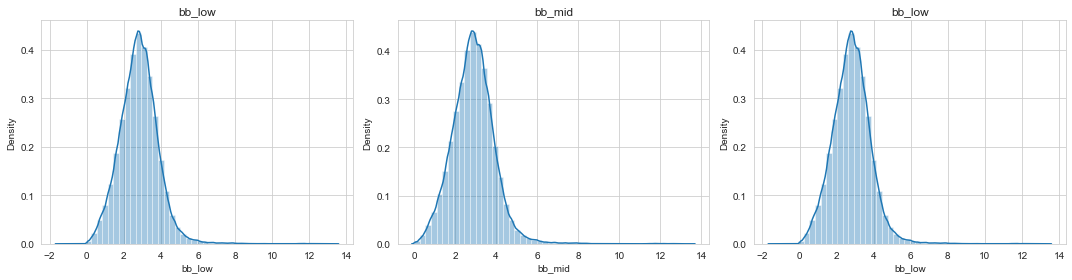

In [19]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
for i, col in enumerate(['bb_low', 'bb_mid', 'bb_low']):
    sns.distplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

In [20]:
prices['bb_up'] = prices.bb_high.sub(np.log1p(prices.close))
prices['bb_down'] = np.log1p(prices.close).sub(prices.bb_low)

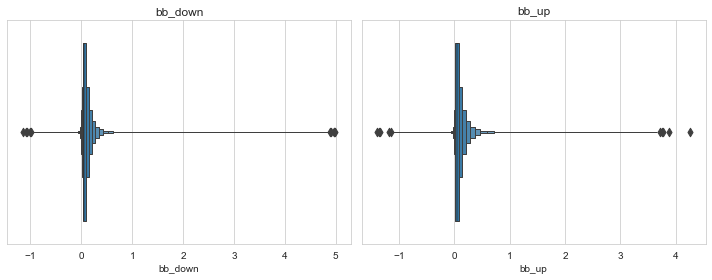

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for i, col in enumerate(['bb_down', 'bb_up']):
    sns.boxenplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

### Compute Average True Range

Helper for indicators with multiple inputs:

In [22]:
by_ticker = prices.groupby('ticker', group_keys=False)

In [23]:
def compute_atr(stock_data):
    atr = ATR(stock_data.high, 
              stock_data.low, 
              stock_data.close, 
              timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())

In [24]:
prices['atr'] = by_ticker.apply(compute_atr)

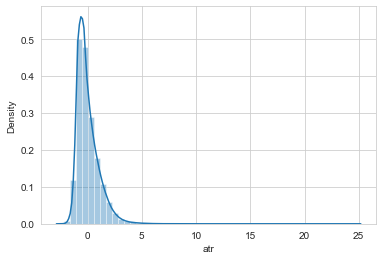

In [25]:
sns.distplot(prices.atr);

In [26]:
prices['natr'] = by_ticker.apply(lambda x: NATR(high=x.high, low=x.low, close=x.close))

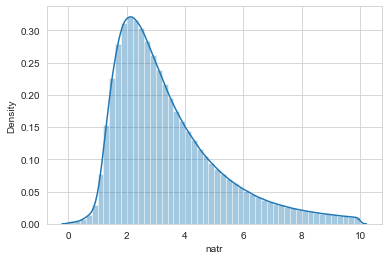

In [27]:
sns.distplot(prices.natr[prices.natr<10]);

### Compute Moving Average Convergence/Divergence

In [28]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

prices['macd'] = prices.groupby(level='ticker').close.apply(compute_macd)

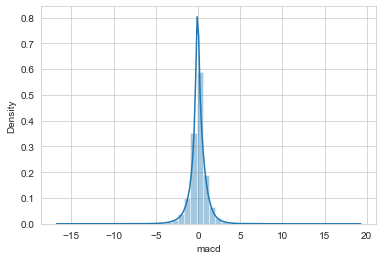

In [29]:
sns.distplot(prices.macd);

## Compute dollar volume to determine universe

In [30]:
prices['dollar_volume'] = (prices.loc[:, 'close']
                           .mul(prices.loc[:, 'volume'], axis=0))

prices.dollar_volume /= 1e6

In [31]:
prices.to_hdf('data.h5', 'us/equities/prices')

In [75]:
prices = pd.read_hdf('data.h5', 'us/equities/prices')
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9532628 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 16 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   open           9532628 non-null  float64
 1   high           9532628 non-null  float64
 2   low            9532628 non-null  float64
 3   close          9532628 non-null  float64
 4   volume         9532628 non-null  float64
 5   sector         9532628 non-null  object 
 6   rsi            9506266 non-null  float64
 7   bb_high        9496851 non-null  float64
 8   bb_mid         9496851 non-null  float64
 9   bb_low         9496851 non-null  float64
 10  bb_up          9496851 non-null  float64
 11  bb_down        9496851 non-null  float64
 12  atr            9506266 non-null  float64
 13  natr           9506266 non-null  float64
 14  macd           9470489 non-null  float64
 15  dollar_volume  9532628 no

## Resample OHLCV prices to monthly frequency

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [76]:
last_cols = [c for c in prices.columns.unique(0) if c not in ['dollar_volume', 'volume',
                                                              'open', 'high', 'low']]

In [77]:
prices = prices.unstack('ticker')

In [78]:
prices

open                                                          \
ticker            AAN       AAON        AAPL       ABAX       ABCB        ABM   
date                                                                            
1995-01-03   1.778191   0.959805    1.235069   3.296526   3.236605   3.436434   
1995-01-04   1.725194   1.006921    1.227128   3.414259   3.173142   3.344280   
1995-01-05   1.778191   1.101914    1.246823   3.649725   3.173142   3.344280   
1995-01-06   1.725194   1.054798    1.322426   4.238390   3.046217   3.362116   
1995-01-09   1.778191   1.082915    1.322426   4.002924   3.046217   3.422940   
...               ...        ...         ...        ...        ...        ...   
2017-12-22  40.080000  36.500000  174.680000  48.790000  49.450000  38.390000   
2017-12-26  40.150000  36.700000  170.800000  49.380000  49.150000  38.110000   
2017-12-27  40.610000  36.650000  170.100000  49.640000  48.600000  38.190000   
2017-12-28  40.520000  36.700000  171.000000  49.100000  48.500000  38.240000   
2017-12-29  40.220000  36.900000  170.520000  49.970000  48.800000  38.010000   

                                                   ... dollar_volume  \
ticker          ABMD        ABT       ACET   ACHC  ...           CIM   
date                                               ...                 
1995-01-03    2.6250   4.268868   1.706428  24.00  ...           NaN   
1995-01-04    2.5625   4.318781   1.605839  24.00  ...           NaN   
1995-01-05    2.8750   4.285944   1.632183  24.00  ...           NaN   
1995-01-06    2.7500   4.268868   1.646553  24.00  ...           NaN   
1995-01-09    2.6875   4.212490   1.646553  24.00  ...           NaN   
...              ...        ...        ...    ...  ...           ...   
2017-12-22  190.9200  57.100000  10.320000  31.93  ...     19.803890   
2017-12-26  191.3100  57.010000  10.310000  32.35  ...     25.760220   
2017-12-27  189.9600  57.090000  10.460000  32.20  ...     24.337094   
2017-12-28  190.5000  57.440000  10.290000  32.49  ...     23.577971   
2017-12-29  190.5600  57.600000  10.200000  32.68  ...     23.556548   

                                                                         \
ticker           ARR         KW       GTS      CATM       FOR       LRN   
date                                                                      
1995-01-03       NaN        NaN       NaN       NaN       NaN       NaN   
1995-01-04       NaN        NaN       NaN       NaN       NaN       NaN   
1995-01-05       NaN        NaN       NaN       NaN       NaN       NaN   
1995-01-06       NaN        NaN       NaN       NaN       NaN       NaN   
1995-01-09       NaN        NaN       NaN       NaN       NaN       NaN   
...              ...        ...       ...       ...       ...       ...   
2017-12-22  8.523758  21.486877  2.316577  5.429883  3.427137  1.811882   
2017-12-26  6.173625  25.633185  1.632204  5.174393  1.903951  2.894652   
2017-12-27  8.119724  26.535988  2.954414  3.857575  2.065709  1.405801   
2017-12-28  6.133750  16.972291  1.387455  4.228009  2.174696  1.470248   
2017-12-29  9.415783  19.849476  5.487452  4.742287  1.814428  1.443513   

                                          
ticker          TITN       TNK       ORN  
date                                      
1995-01-03       NaN       NaN       NaN  
1995-01-04       NaN       NaN       NaN  
1995-01-05       NaN       NaN       NaN  
1995-01-06       NaN       NaN       NaN  
1995-01-09       NaN       NaN       NaN  
...              ...       ...       ...  
2017-12-22  3.851540  1.606720  0.273170  
2017-12-26  3.485999  1.427873  0.233545  
2017-12-27  2.093023  1.407286  0.256812  
2017-12-28  3.247877  1.759440  0.256760  
2017-12-29  2.188131  1.963333  0.601501  

[5822 rows x 30128 columns]

In [35]:
data = (pd.concat([prices.dollar_volume.resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   prices[last_cols].resample('M').last().stack('ticker')],
                  axis=1)
        .swaplevel()
        .dropna())

In [36]:
data

,,dollar_volume,atr,bb_down,bb_high,bb_low,bb_mid,bb_up,close,macd,natr,rsi,sector
ticker,date,,,,,,,,,,,,
AAN,1995-02-28,0.076234,-0.901701,0.094985,1.102449,1.022490,1.062469,-0.015025,2.057123,-0.018766,2.986767,65.510236,Technology
AAON,1995-02-28,0.648475,-0.776136,0.011130,0.724783,0.656662,0.690722,0.056992,0.949926,-0.300224,5.914937,43.638603,Capital Goods
AAPL,1995-02-28,91.764760,-0.807437,0.018716,0.883378,0.795854,0.839616,0.068807,1.258206,-0.245760,3.714928,44.914285,Technology
ABAX,1995-02-28,0.130321,-0.795972,0.211246,1.720151,1.374962,1.547557,0.133943,3.885191,0.142463,9.825437,53.251518,Capital Goods
ABCB,1995-02-28,0.014540,-1.058002,0.054657,1.471694,1.389106,1.430400,0.027932,3.236605,-0.049239,3.337611,52.835867,Finance
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZEUS,2017-12-31,2.367517,-0.268761,0.061454,3.168421,3.051617,3.110019,0.055350,21.490000,0.615364,3.380065,54.357447,Basic Industries
ZION,2017-12-31,104.045818,0.070423,0.028298,3.968271,3.919671,3.943971,0.020302,50.830000,0.970972,2.018365,57.076071,Finance
ZIOP,2017-12-31,7.197808,-0.242063,0.039425,1.710400,1.597628,1.654014,0.073347,4.140000,-0.306141,6.112761,44.348071,Health Care


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 452529 entries, ('AAN', Timestamp('1995-02-28 00:00:00')) to ('ZUMZ', Timestamp('2017-12-31 00:00:00'))
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   dollar_volume  452529 non-null  float64
 1   atr            452529 non-null  float64
 2   bb_down        452529 non-null  float64
 3   bb_high        452529 non-null  float64
 4   bb_low         452529 non-null  float64
 5   bb_mid         452529 non-null  float64
 6   bb_up          452529 non-null  float64
 7   close          452529 non-null  float64
 8   macd           452529 non-null  float64
 9   natr           452529 non-null  float64
 10  rsi            452529 non-null  float64
 11  sector         452529 non-null  object 
dtypes: float64(11), object(1)
memory usage: 43.2+ MB


## Select 500 most-traded equities

Select the 500 most-traded stocks based on a 5-year rolling average of dollar volume.

In [38]:
data = data.sort_index(level='ticker')
data['dollar_volume'] = (data
                                 .groupby('ticker',
                                          group_keys=False,
                                          as_index=False)
                                 .dollar_volume
                                 .rolling(window=5*12)
                                 .mean()
                                 .fillna(0)
                                 .reset_index(level=0, drop=True).values)

In [39]:
data

dollar_volume       atr   bb_down   bb_high    bb_low  \
ticker date                                                                
A      2000-01-31       0.000000  1.731295  0.063414  3.932485  3.768645   
       2000-02-29       0.000000  3.959243  0.454710  4.348944  3.820355   
       2000-03-31       0.000000  7.153952  0.063142  4.691676  4.212871   
       2000-04-30       0.000000  5.814687  0.138404  4.366761  3.980096   
       2000-05-31       0.000000  5.092544  0.254224  4.255311  3.682167   
...                          ...       ...       ...       ...       ...   
ZUMZ   2017-08-31       9.617008 -1.406519  0.079850  2.672887  2.519129   
       2017-09-30       9.403901 -1.102668  0.325987  3.031582  2.623702   
       2017-10-31       9.280583 -1.044057  0.049685  2.997011  2.876161   
       2017-11-30       9.149301 -0.454277  0.257731  3.092331  2.869030   
       2017-12-31       9.165877 -0.668948  0.041582  3.135397  3.041474   

                     bb_mid     bb_up      close      macd       natr  \
ticker date                                                             
A      2000-01-31  3.850565  0.100425  45.157511  2.020591   5.541014   
       2000-02-29  4.084650  0.073879  70.884807  6.192176   6.447519   
       2000-03-31  4.452273  0.415662  70.953031  0.750543  10.620898   
       2000-04-30  4.173429  0.248261  60.466992 -3.503484  10.406763   
       2000-05-31  3.968739  0.318920  50.233382 -4.444144  11.192390   
...                     ...       ...        ...       ...        ...   
ZUMZ   2017-08-31  2.596008  0.073908  12.450000  0.033768   4.406561   
       2017-09-30  2.827642  0.081894  18.100000  1.240790   3.646648   
       2017-10-31  2.936586  0.071165  17.650000  0.334190   3.861397   
       2017-11-30  2.980680 -0.034430  21.800000  0.857650   4.118427   
       2017-12-31  3.088436  0.052341  20.825000  0.535921   3.933227   

                         rsi             sector  
ticker date                                      
A      2000-01-31  53.739148      Capital Goods  
       2000-02-29  69.500618      Capital Goods  
       2000-03-31  43.861800      Capital Goods  
       2000-04-30  43.325747      Capital Goods  
       2000-05-31  45.985738      Capital Goods  
...                      ...                ...  
ZUMZ   2017-08-31  49.004517  Consumer Services  
       2017-09-30  74.991384  Consumer Services  
       2017-10-31  52.782217  Consumer Services  
       2017-11-30  74.239531  Consumer Services  
       2017-12-31  52.959469  Consumer Services  

[452529 rows x 12 columns]

In [40]:
data['dollar_vol_rank'] = (data
                           .groupby('date')
                           .dollar_volume
                           .rank(ascending=False))
data

dollar_volume       atr   bb_down   bb_high    bb_low  \
ticker date                                                                
A      2000-01-31       0.000000  1.731295  0.063414  3.932485  3.768645   
       2000-02-29       0.000000  3.959243  0.454710  4.348944  3.820355   
       2000-03-31       0.000000  7.153952  0.063142  4.691676  4.212871   
       2000-04-30       0.000000  5.814687  0.138404  4.366761  3.980096   
       2000-05-31       0.000000  5.092544  0.254224  4.255311  3.682167   
...                          ...       ...       ...       ...       ...   
ZUMZ   2017-08-31       9.617008 -1.406519  0.079850  2.672887  2.519129   
       2017-09-30       9.403901 -1.102668  0.325987  3.031582  2.623702   
       2017-10-31       9.280583 -1.044057  0.049685  2.997011  2.876161   
       2017-11-30       9.149301 -0.454277  0.257731  3.092331  2.869030   
       2017-12-31       9.165877 -0.668948  0.041582  3.135397  3.041474   

                     bb_mid     bb_up      close      macd       natr  \
ticker date                                                             
A      2000-01-31  3.850565  0.100425  45.157511  2.020591   5.541014   
       2000-02-29  4.084650  0.073879  70.884807  6.192176   6.447519   
       2000-03-31  4.452273  0.415662  70.953031  0.750543  10.620898   
       2000-04-30  4.173429  0.248261  60.466992 -3.503484  10.406763   
       2000-05-31  3.968739  0.318920  50.233382 -4.444144  11.192390   
...                     ...       ...        ...       ...        ...   
ZUMZ   2017-08-31  2.596008  0.073908  12.450000  0.033768   4.406561   
       2017-09-30  2.827642  0.081894  18.100000  1.240790   3.646648   
       2017-10-31  2.936586  0.071165  17.650000  0.334190   3.861397   
       2017-11-30  2.980680 -0.034430  21.800000  0.857650   4.118427   
       2017-12-31  3.088436  0.052341  20.825000  0.535921   3.933227   

                         rsi             sector  dollar_vol_rank  
ticker date                                                       
A      2000-01-31  53.739148      Capital Goods           1217.0  
       2000-02-29  69.500618      Capital Goods           1220.5  
       2000-03-31  43.861800      Capital Goods           1224.0  
       2000-04-30  43.325747      Capital Goods           1227.5  
       2000-05-31  45.985738      Capital Goods           1235.0  
...                      ...                ...              ...  
ZUMZ   2017-08-31  49.004517  Consumer Services           1041.0  
       2017-09-30  74.991384  Consumer Services           1053.0  
       2017-10-31  52.782217  Consumer Services           1067.0  
       2017-11-30  74.239531  Consumer Services           1072.0  
       2017-12-31  52.959469  Consumer Services           1078.0  

[452529 rows x 13 columns]

In [41]:
data = data[data.dollar_vol_rank < 500].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)
data

atr   bb_down   bb_high    bb_low    bb_mid     bb_up  \
ticker date                                                                     
A      2004-12-31 -0.501823  0.025098  2.871296  2.833783  2.852539  0.012415   
       2005-01-31 -0.556859  0.041946  2.835474  2.735900  2.785687  0.057628   
       2005-02-28 -0.513495  0.081041  2.877209  2.773921  2.825565  0.022247   
       2005-03-31 -0.560471  0.026685  2.886538  2.754971  2.820754  0.104881   
       2005-04-30 -0.588829  0.018703  2.765774  2.699726  2.732750  0.047345   
...                     ...       ...       ...       ...       ...       ...   
ZIXI   2004-06-30  0.048753  0.020821  2.285838  2.164106  2.224972  0.100911   
       2004-07-31 -0.060901  0.160655  2.098204  1.765053  1.931628  0.172496   
       2004-08-31 -0.175613  0.080019  1.781207  1.558978  1.670092  0.142210   
       2004-09-30 -0.242284  0.069699  1.781693  1.649490  1.715592  0.062505   
       2004-10-31 -0.185498  0.061670  1.960903  1.794628  1.877765  0.104605   

                       close      macd      natr        rsi         sector  
ticker date                                                                 
A      2004-12-31  16.442001  0.016797  2.610740  53.472599  Capital Goods  
       2005-01-31  15.084342 -0.336030  2.507037  44.538959  Capital Goods  
       2005-02-28  16.373776  0.106785  2.555450  58.619145  Capital Goods  
       2005-03-31  15.145743 -0.261483  2.474736  37.479382  Capital Goods  
       2005-04-30  14.156494 -0.301839  2.461723  39.733904  Capital Goods  
...                      ...       ...       ...        ...            ...  
ZIXI   2004-06-30   7.890000 -0.325707  8.688506  42.416032     Technology  
       2004-07-31   5.860000 -0.581416  9.298457  43.217095     Technology  
       2004-08-31   4.150000 -0.344236  9.584806  38.996288     Technology  
       2004-09-30   4.580000 -0.028589  6.817959  49.176603     Technology  
       2004-10-31   5.400000  0.156593  7.131332  51.353981     Technology  

[107784 rows x 11 columns]

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 107784 entries, ('A', Timestamp('2004-12-31 00:00:00')) to ('ZIXI', Timestamp('2004-10-31 00:00:00'))
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   atr      107784 non-null  float64
 1   bb_down  107784 non-null  float64
 2   bb_high  107784 non-null  float64
 3   bb_low   107784 non-null  float64
 4   bb_mid   107784 non-null  float64
 5   bb_up    107784 non-null  float64
 6   close    107784 non-null  float64
 7   macd     107784 non-null  float64
 8   natr     107784 non-null  float64
 9   rsi      107784 non-null  float64
 10  sector   107784 non-null  object 
dtypes: float64(10), object(1)
memory usage: 9.5+ MB


In [43]:
len(data.index.unique('ticker'))

842

## Create monthly return series

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [44]:
outlier_cutoff = 0.01
lags = [1, 3, 6, 12]
returns = []

In [45]:
for lag in lags:
    returns.append(data
                   .close
                   .unstack('ticker')
                   .sort_index()
                   .pct_change(lag)
                   .stack('ticker')
                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                          upper=x.quantile(1-outlier_cutoff)))
                   .add(1)
                   .pow(1/lag)
                   .sub(1)
                   .to_frame(f'return_{lag}m')
                   )
    
returns = pd.concat(returns, axis=1).swaplevel()
returns.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 154206 entries, ('AAPL', Timestamp('2000-02-29 00:00:00')) to ('ZIXI', Timestamp('2017-12-31 00:00:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   154206 non-null  float64
 1   return_3m   152522 non-null  float64
 2   return_6m   150006 non-null  float64
 3   return_12m  145000 non-null  float64
dtypes: float64(4)
memory usage: 5.3+ MB


In [46]:
returns.describe()

,return_1m,return_3m,return_6m,return_12m
count,154206.000000,152522.000000,150006.000000,145000.000000
mean,0.007069,0.004762,0.004129,0.003821
std,0.083222,0.048868,0.035565,0.025336
min,-0.264615,-0.173225,-0.130623,-0.089656
25%,-0.016393,-0.006011,-0.002583,-0.000429
50%,0.000000,0.000000,0.000000,0.000000
75%,0.037313,0.025775,0.020045,0.015872
max,0.304386,0.160774,0.113208,0.081740


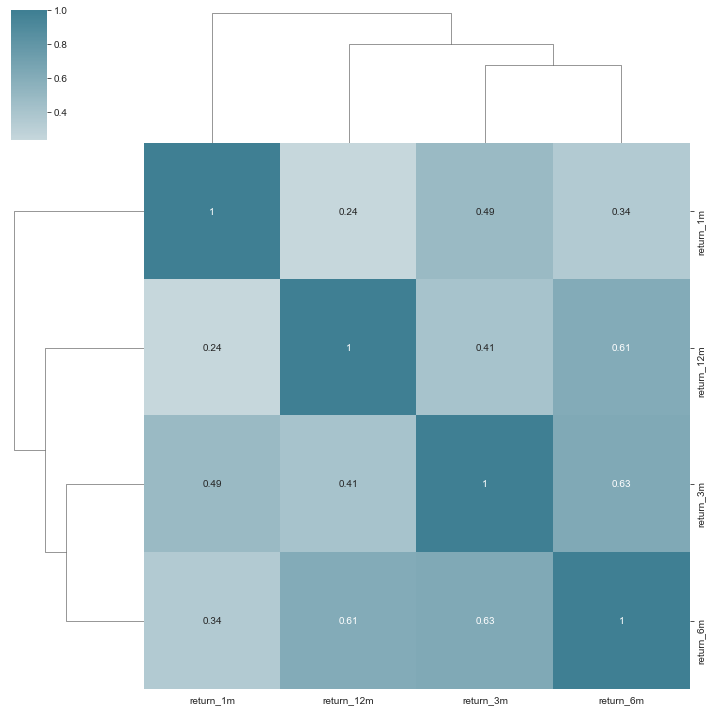

In [47]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap=cmap);

In [48]:
data = data.join(returns).drop('close', axis=1).dropna()
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 98127 entries, ('A', Timestamp('2005-12-31 00:00:00')) to ('ZIXI', Timestamp('2004-10-31 00:00:00'))
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   atr         98127 non-null  float64
 1   bb_down     98127 non-null  float64
 2   bb_high     98127 non-null  float64
 3   bb_low      98127 non-null  float64
 4   bb_mid      98127 non-null  float64
 5   bb_up       98127 non-null  float64
 6   macd        98127 non-null  float64
 7   natr        98127 non-null  float64
 8   rsi         98127 non-null  float64
 9   sector      98127 non-null  object 
 10  return_1m   98127 non-null  float64
 11  return_3m   98127 non-null  float64
 12  return_6m   98127 non-null  float64
 13  return_12m  98127 non-null  float64
dtypes: float64(13), object(1)
memory usage: 10.9+ MB


In [49]:
min_obs = 5*12
nobs = data.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
data = data.drop(to_drop, level='ticker')

In [50]:
len(data.index.unique('ticker'))

578

We are left with 787 tickers.

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 8, Time Series Models]([](../../08_time_series_models)).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `PandasRollingOLS` rolling linear regression functionality in the `pyfinance` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [51]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                             'famafrench', 
                             start=START)[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 313 entries, 1995-01-31 to 2021-01-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  313 non-null    float64
 1   SMB     313 non-null    float64
 2   HML     313 non-null    float64
 3   RMW     313 non-null    float64
 4   CMA     313 non-null    float64
dtypes: float64(5)
memory usage: 14.7 KB


In [52]:
factor_data = factor_data.join(data['return_1m']).dropna().sort_index()
factor_data['return_1m'] -= factor_data['Mkt-RF']
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 92011 entries, ('A', Timestamp('2005-12-31 00:00:00', freq='M')) to ('ZION', Timestamp('2017-12-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Mkt-RF     92011 non-null  float64
 1   SMB        92011 non-null  float64
 2   HML        92011 non-null  float64
 3   RMW        92011 non-null  float64
 4   CMA        92011 non-null  float64
 5   return_1m  92011 non-null  float64
dtypes: float64(6)
memory usage: 4.7+ MB


In [53]:
factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
count,92011.000000,92011.000000,92011.000000,92011.000000,92011.000000,92011.000000
mean,0.005727,0.003179,0.001334,0.003528,0.001673,0.004407
std,0.042298,0.025572,0.026778,0.022366,0.018238,0.081359
min,-0.172300,-0.062600,-0.111200,-0.089300,-0.065500,-0.378115
25%,-0.018300,-0.013500,-0.012300,-0.009400,-0.010400,-0.039825
50%,0.010900,0.002300,-0.000500,0.004200,-0.000400,0.002594
75%,0.031300,0.021300,0.015700,0.014100,0.010600,0.046403
max,0.113500,0.069400,0.125800,0.090900,0.095600,0.476686


In [54]:
T = 60
betas = (factor_data
         .groupby(level='ticker', group_keys=False)
         .apply(lambda x: PandasRollingOLS(window=min(T, x.shape[0]-1), 
                                           y=x.return_1m, 
                                           x=x.drop('return_1m', axis=1)).beta)
        .rename(columns={'Mkt-RF': 'beta'}))

In [55]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,57912.000000,57912.000000,57912.000000,57912.000000,57912.000000,57912.000000
mean,0.039691,0.195953,0.053220,-0.022509,0.013714,0.280068
std,0.453860,0.590777,0.802086,0.875856,0.990064,1.659068
min,-1.825339,-1.936586,-4.051906,-5.153343,-5.199229,-9.941890
25%,-0.267571,-0.211273,-0.453102,-0.512255,-0.561508,-0.709854
50%,0.025527,0.153442,-0.033632,0.027746,0.054941,0.230457
75%,0.327846,0.571050,0.480997,0.515799,0.626819,1.237405
max,2.572350,2.650667,4.583075,3.939430,4.773809,10.003515


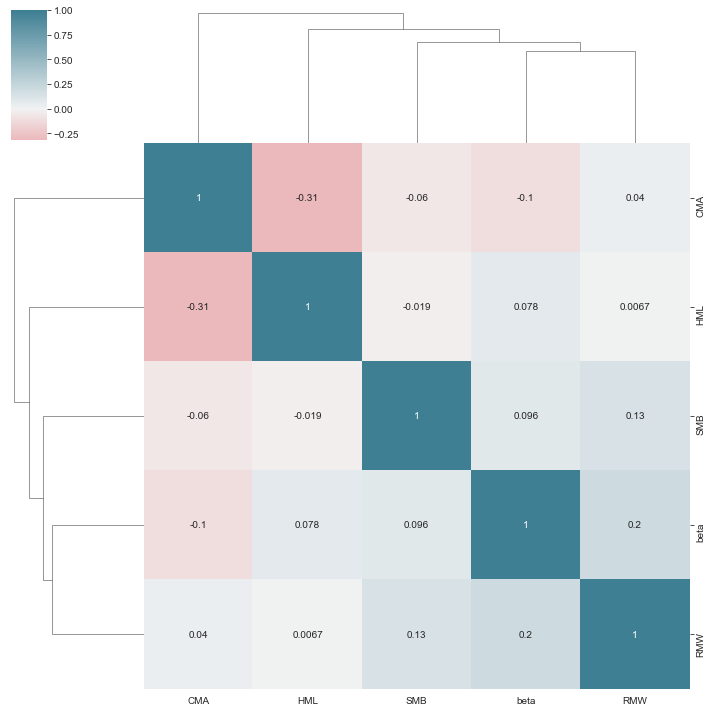

In [56]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [57]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift())
       .dropna()
       .sort_index())

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 57334 entries, ('A', Timestamp('2010-12-31 00:00:00')) to ('ZION', Timestamp('2017-12-31 00:00:00'))
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   atr         57334 non-null  float64
 1   bb_down     57334 non-null  float64
 2   bb_high     57334 non-null  float64
 3   bb_low      57334 non-null  float64
 4   bb_mid      57334 non-null  float64
 5   bb_up       57334 non-null  float64
 6   macd        57334 non-null  float64
 7   natr        57334 non-null  float64
 8   rsi         57334 non-null  float64
 9   sector      57334 non-null  object 
 10  return_1m   57334 non-null  float64
 11  return_3m   57334 non-null  float64
 12  return_6m   57334 non-null  float64
 13  return_12m  57334 non-null  float64
 14  beta        57334 non-null  float64
 15  SMB         57334 non-null  float64
 16  HML         57334 non-null  float64
 17  RMW         57334 non-null  floa

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [59]:
for lag in [3, 6, 12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
    if lag > 3:
        data[f'momentum_3_{lag}'] = data[f'return_{lag}m'].sub(data.return_3m)    

## Date Indicators

In [60]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Target: Holding Period Returns

To compute returns for our one-month target holding period, we use the returns computed previously and shift them back to align them with the current financial features.

In [61]:
data['target'] = data.groupby(level='ticker')[f'return_1m'].shift(-1)

In [62]:
data = data.dropna()

In [63]:
data.sort_index().info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 56756 entries, ('A', Timestamp('2010-12-31 00:00:00')) to ('ZION', Timestamp('2017-11-30 00:00:00'))
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   atr            56756 non-null  float64
 1   bb_down        56756 non-null  float64
 2   bb_high        56756 non-null  float64
 3   bb_low         56756 non-null  float64
 4   bb_mid         56756 non-null  float64
 5   bb_up          56756 non-null  float64
 6   macd           56756 non-null  float64
 7   natr           56756 non-null  float64
 8   rsi            56756 non-null  float64
 9   sector         56756 non-null  object 
 10  return_1m      56756 non-null  float64
 11  return_3m      56756 non-null  float64
 12  return_6m      56756 non-null  float64
 13  return_12m     56756 non-null  float64
 14  beta           56756 non-null  float64
 15  SMB            56756 non-null  float64
 16  HML            5675

## Sector Breakdown

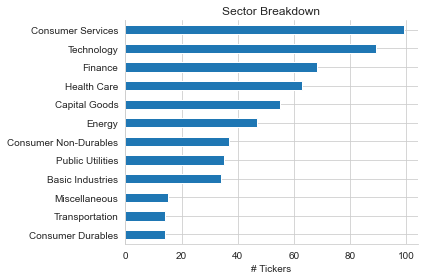

In [64]:
ax = data.reset_index().groupby('sector').ticker.nunique().sort_values().plot.barh(title='Sector Breakdown')
ax.set_ylabel('')
ax.set_xlabel('# Tickers')
sns.despine()
plt.tight_layout();

## Store data

In [65]:
with pd.HDFStore('data.h5') as store:
    store.put('us/equities/monthly', data)

## Evaluate mutual information

In [66]:
X = data.drop('target', axis=1)
X.sector = pd.factorize(X.sector)[0]

In [67]:
mi = mutual_info_regression(X=X, y=data.target)

In [68]:
mi_reg = pd.Series(mi, index=X.columns)
mi_reg.nlargest(10)

natr             0.109573
return_12m       0.062334
return_6m        0.052940
year             0.051989
return_3m        0.050311
momentum_12      0.040821
bb_low           0.040697
momentum_3_6     0.040542
bb_up            0.039806
momentum_3_12    0.038946
dtype: float64

In [69]:
mi = mutual_info_classif(X=X, y=(data.target>0).astype(int))

In [70]:
mi_class = pd.Series(mi, index=X.columns)
mi_class.nlargest(10)

year          0.013621
month         0.009611
return_6m     0.003810
sector        0.003622
natr          0.003493
return_12m    0.003216
bb_low        0.002777
macd          0.001823
return_1m     0.001462
momentum_6    0.001135
dtype: float64

In [71]:
mi = mi_reg.to_frame('Regression').join(mi_class.to_frame('Classification'))

In [72]:
mi.index = [' '.join(c.upper().split('_')) for c in mi.index]

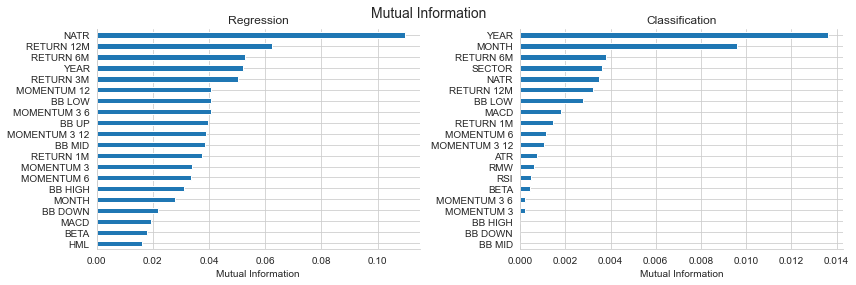

In [73]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for i, t in enumerate(['Regression', 'Classification']):
    mi[t].nlargest(20).sort_values().plot.barh(title=t, ax=axes[i])
    axes[i].set_xlabel('Mutual Information')
fig.suptitle('Mutual Information', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)